<a href="https://colab.research.google.com/github/ariana-caetano/data-engineering/blob/main/AcelerandoProcessamentoDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acelerando o processamento de dados no Pandas

<div align="center"><img src="https://static.wixstatic.com/media/f9d0a3_0e4b8cf77ae44bbf9dd6d525ed31c85e~mv2.gif" width=500/>
</div>


Li e assisti alguns vídeos com dicas de como é possível melhorar a velocidade de processamento de dados, utilizando Pandas. E nesse artigo vou compartilhar com vocês.

### Criando um dataframe genérico

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#criando uma função para criar um dataframe fake que será utilizado nas comparações de performance

def create_dataframe(size, cols_type):
  '''
    size = quantidade de linhas do dataframe
    cols_type = quantidade e o tipo de dados de cada coluna
    os tipos possíveis de dados são:
    "c" : "cat" 
    "i" : "int" 
    "f" : "float" 
    "d" : "date"
    (por exemplo: cols_type = ciif serão 4 colunas com os seguintes tipos de dados categoria, inteiro, inteiro, float)
  '''
  suffix = {"c" : "cat", "i" : "int", "f" : "float", "d" : "date"}
  col_names = [f"column_{str(i)}_{suffix.get(col)}" for i, col in enumerate(cols_type)]

  df = pd.DataFrame()
  for col, col_name in zip(cols_type, col_names):
    if col=='c':
      df[col_name] = np.random.choice(['yes','no'], size)
    elif col=='i':
      df[col_name] = np.random.randint(1, 50, size)
    elif col=='f':
      df[col_name] = np.random.uniform(0, 1, size)
    else:
      dates = pd.date_range('2020-01-01', '2022-12-31')
      df[col_name] = np.random.choice(dates, size)

  return df

In [ ]:
#e aqui temos o nosso dataframe
create_dataframe(10, 'ciifd')

,column_0_cat,column_1_int,column_2_int,column_3_float,column_4_date
0,yes,27,7,0.793021,2021-05-30
1,yes,48,4,0.845378,2022-12-17
2,no,38,30,0.153733,2021-01-27
3,no,32,18,0.784998,2021-06-20
4,no,13,38,0.459888,2021-07-11
5,yes,43,14,0.353971,2020-03-14
6,yes,22,45,0.018539,2020-12-30
7,yes,34,39,0.236602,2021-09-08
8,no,14,39,0.349280,2020-08-27
9,no,28,27,0.406226,2020-09-24


Essa função de criar o dataframe genérico vai facilitar nossos testes, pois poderemos criar vários dataframes, com a quantidade de linhas e colunas que quisermos.

### Criando um problema

Agora vamos inventar um problema para resolvermos:

* Se a coluna `column_1_int` for maior que 25 e a `column_3_float` for maior que 0.5 então `new_column` será igual a yes;
* Senão ela será igual a no;
* Se a coluna `column_2_int` for maior que 40 a `new_column` será igual a yes

Os dados e o problema são bastante fictícios nesse exemplo, mas a criação de uma nova coluna baseado em critérios de outras colunas acontece com frequência.


In [ ]:
#função para aplicar as regras que criamos acima
def new_column_data(row):
  if row['column_2_int'] > 40:
    return 'yes'
  if (row['column_1_int'] > 25) & (row['column_3_float'] > 0.5):
    return 'yes'
  return 'no'

### Aplicando as regras e criando a nova coluna



Vamos utilizar uma função no Python que vai nos mostrar o tempo gasto na execução de cada um dos métodos que utilizaremos para solucionar e criar a nossa nova coluna.
A função é a `%%timeit`

#### 1. Usando Loop

In [ ]:
%%timeit
df = create_dataframe(10000, 'ciifdcffd')
for index, row in df.iterrows():
  df.loc[index, 'new_column'] = new_column_data(row)

4.96 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 2. Usando Apply

In [ ]:
%%timeit
df = create_dataframe(10000, 'ciifdcffd')
df['new_column'] = df.apply(new_column_data, axis=1)

219 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 3. Usando Vetorização

E aqui está a mágica.

A vetorização.

A vetorização é usada para acelerar o código Python sem usar loop. Seu uso pode ajudar a minimizar o tempo de execução do código de forma eficiente.
Aqui a função é aplicada no dataframe inteiro ao invés de aplicar linha a linha.

In [ ]:
%%timeit
df = create_dataframe(10000, 'ciifdcffd')
df['new_column'] = 'no'
df.loc[((df['column_1_int'] > 25) & 
        (df['column_3_float'] > 0.5)) | 
        (df['column_2_int'] > 40), 'new_column'] = 'yes'

15 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Resultados

In [ ]:
results = pd.DataFrame(
    [
        ['loop', 4960],
        ['apply', 219],
        ['vetorizacao', 15]
    ],
    columns=['type', 'time']
)

In [ ]:
results

,type,time
0,loop,4960
1,apply,219
2,vetorizacao,15


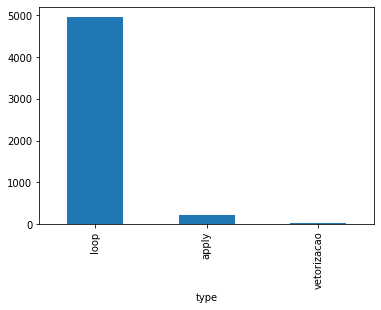

In [ ]:
results.set_index('type')['time'].plot(kind='bar')

A vetorização se mostrou o método com melhor desempenho, sendo muitas vezes mais rápida que o uso de loop.

### Dica bônus

E qual o melhor formato para salvar um arquivo, qual o tipo de dado deixa nosso dataframe mais eficiente?

#### Tipos de dados

Esse é um tópico importante, ao qual devemos nos atentar na hora de tratar os dados e tentar deixá-los sempre no melhor e menor formato possivel.

Vamos fazer alguns testes aqui também!

In [ ]:
#nos testes anteriores criamos um dataframe de apenas 1.000.000 de linhas
#vamos criar um pouco maior agora 5.000.000 e ver o impacto no tamanho do nosso dataframe

df = create_dataframe(5000000, 'ciifdcffd')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    object        
 1   column_1_int    int64         
 2   column_2_int    int64         
 3   column_3_float  float64       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    object        
 6   column_6_float  float64       
 7   column_7_float  float64       
 8   column_8_date   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(2), object(2)
memory usage: 343.3+ MB


Vamos começar alterando as colunas categóricas para o tipo `category` 

In [ ]:
df['column_0_cat'] = df['column_0_cat'].astype('category')
df['column_5_cat'] = df['column_5_cat'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    category      
 1   column_1_int    int64         
 2   column_2_int    int64         
 3   column_3_float  float64       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    category      
 6   column_6_float  float64       
 7   column_7_float  float64       
 8   column_8_date   datetime64[ns]
dtypes: category(2), datetime64[ns](2), float64(3), int64(2)
memory usage: 276.6 MB


O tamanho do nosso dataframe foi reduzido.

Redução de: 343.3MB

Para: 276.6 MB

Nesse caso podemos melhorar ainda mais a coluna de categoria, pois temos apenas 2 categorias: yes/no. Então podemos definí-la como booleana (true/false).

In [ ]:
df['column_0_cat'] = df['column_0_cat'].map({'yes':True, 'no': False})
df['column_5_cat'] = df['column_5_cat'].map({'yes':True, 'no': False})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    category      
 1   column_1_int    int64         
 2   column_2_int    int64         
 3   column_3_float  float64       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    category      
 6   column_6_float  float64       
 7   column_7_float  float64       
 8   column_8_date   datetime64[ns]
dtypes: category(2), datetime64[ns](2), float64(3), int64(2)
memory usage: 276.6 MB


E qual foi a redução? 
Nesse caso não houve, mas é uma opção de formatação de tipo de dado.


Agora vamos escolher o tipo inteiro mais adequado

In [ ]:
# mostra os valores limites para cada tipo int
print(np.iinfo(np.int8))

print(np.iinfo(np.int16))

print(np.iinfo(np.int32))

print(np.iinfo(np.int64))  

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



In [ ]:
#o range das colunas do tipo inteiro é de 1 a 49
print(df['column_1_int'].min())
print(df['column_1_int'].max())
print(df['column_2_int'].min())
print(df['column_2_int'].max())

1
49
1
49


In [ ]:
#podemos utilizar aqui int8
df['column_1_int'] = df['column_1_int'].astype('int8')
df['column_2_int'] = df['column_2_int'].astype('int8')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    category      
 1   column_1_int    int8          
 2   column_2_int    int8          
 3   column_3_float  float64       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    category      
 6   column_6_float  float64       
 7   column_7_float  float64       
 8   column_8_date   datetime64[ns]
dtypes: category(2), datetime64[ns](2), float64(3), int8(2)
memory usage: 209.8 MB


Redução de: 276.6MB

Para: 209.8MB

E para o tipo float?

In [ ]:
# mostra os valores limites para cada tipo float
print(np.finfo(np.float16))

print(np.finfo(np.float32))

print(np.finfo(np.float64)) 

Machine parameters for float16
---------------------------------------------------------------
precision =   3   resolution = 1.00040e-03
machep =    -10   eps =        9.76562e-04
negep =     -11   epsneg =     4.88281e-04
minexp =    -14   tiny =       6.10352e-05
maxexp =     16   max =        6.55040e+04
nexp =        5   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   e

Para o tipo float é um pouco diferente, pois as alterações são realizadas na precisão do número. Então é extremamente necessário avaliar caso a caso, em cima dos dados reais.

In [ ]:
#original
df['column_3_float']

0          0.212001
1          0.650490
2          0.059632
3          0.987894
4          0.007178
             ...   
4999995    0.030632
4999996    0.461034
4999997    0.177647
4999998    0.681306
4999999    0.361494
Name: column_3_float, Length: 5000000, dtype: float64

In [ ]:
#float32
df['column_3_float'].astype('float32')

0          0.212001
1          0.650490
2          0.059632
3          0.987894
4          0.007178
             ...   
4999995    0.030632
4999996    0.461034
4999997    0.177647
4999998    0.681306
4999999    0.361494
Name: column_3_float, Length: 5000000, dtype: float32

In [ ]:
#float16
df['column_3_float'].astype('float16')

0          0.212036
1          0.650391
2          0.059631
3          0.987793
4          0.007179
             ...   
4999995    0.030624
4999996    0.460938
4999997    0.177612
4999998    0.681152
4999999    0.361572
Name: column_3_float, Length: 5000000, dtype: float16

In [ ]:
# com float32 as alterações na precisão não foram percebidas
df['column_3_float'] = df['column_3_float'].astype('float32')
df['column_6_float'] = df['column_6_float'].astype('float32')
df['column_7_float'] = df['column_7_float'].astype('float32')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    category      
 1   column_1_int    int8          
 2   column_2_int    int8          
 3   column_3_float  float32       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    category      
 6   column_6_float  float32       
 7   column_7_float  float32       
 8   column_8_date   datetime64[ns]
dtypes: category(2), datetime64[ns](2), float32(3), int8(2)
memory usage: 152.6 MB


Redução de: 209.8MB

Para: 152.6 MB

In [ ]:
results = pd.DataFrame(
    [
        ['original', 343.3],
        ['custom_types', 152.6],
    ],
    columns=['file', 'size']
)

In [ ]:
results

,file,size
0,original,343.3
1,custom_types,152.6


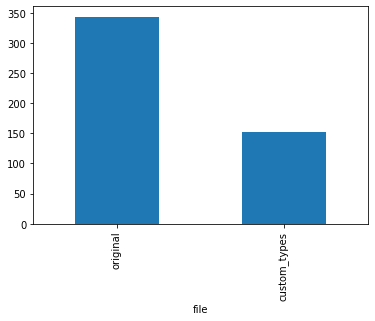

In [ ]:
results.set_index('file')['size'].plot(kind='bar')

É nítida a redução do tamanho do arquivo.

Vamos fazer mais um teste? Executar nossa função de vetorização antes e depois do casting nos dados.

In [ ]:
del df

In [ ]:
df = create_dataframe(5000000, 'ciifdcffd')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    object        
 1   column_1_int    int64         
 2   column_2_int    int64         
 3   column_3_float  float64       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    object        
 6   column_6_float  float64       
 7   column_7_float  float64       
 8   column_8_date   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(2), object(2)
memory usage: 343.3+ MB


In [ ]:
%%timeit
df['new_column'] = 'no'
df.loc[((df['column_1_int'] > 25) & 
        (df['column_3_float'] > 0.5)) | 
        (df['column_2_int'] > 40), 'new_column'] = 'yes'

227 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
df

,column_0_cat,column_1_int,column_2_int,column_3_float,column_4_date,column_5_cat,column_6_float,column_7_float,column_8_date,new_column
0,no,49,32,0.661162,2022-04-02,no,0.198257,0.862592,2021-09-20,yes
1,yes,47,9,0.627424,2021-11-15,yes,0.099039,0.941127,2022-10-18,yes
2,no,33,18,0.355638,2020-10-12,yes,0.581677,0.416596,2021-10-08,no
3,yes,13,26,0.621346,2021-02-10,yes,0.286015,0.443199,2021-04-24,no
4,yes,46,40,0.353482,2021-11-25,no,0.677347,0.325568,2022-05-05,no
...,...,...,...,...,...,...,...,...,...,...
4999995,no,21,33,0.673541,2021-05-22,yes,0.317783,0.224820,2020-11-24,no
4999996,yes,44,38,0.489869,2021-10-15,no,0.738659,0.063281,2020-06-17,no
4999997,yes,48,24,0.801902,2022-01-13,yes,0.946859,0.607965,2021-11-05,yes
4999998,yes,29,46,0.253213,2020-07-13,yes,0.569812,0.484182,2021-01-26,yes


In [ ]:
def set_types(df):  
  df['column_0_cat'] = df['column_0_cat'].astype('category')
  df['column_1_int'] = df['column_1_int'].astype('int8')
  df['column_2_int'] = df['column_2_int'].astype('int8')
  df['column_3_float'] = df['column_3_float'].astype('float32')
  df['column_5_cat'] = df['column_5_cat'].astype('category')
  df['column_6_float'] = df['column_6_float'].astype('float32')
  df['column_7_float'] = df['column_7_float'].astype('float32')
  return df


In [ ]:
df = set_types(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   column_0_cat    bool          
 1   column_1_int    int8          
 2   column_2_int    int8          
 3   column_3_float  float32       
 4   column_4_date   datetime64[ns]
 5   column_5_cat    bool          
 6   column_6_float  float32       
 7   column_7_float  float32       
 8   column_8_date   datetime64[ns]
 9   new_column      object        
dtypes: bool(2), datetime64[ns](2), float32(3), int8(2), object(1)
memory usage: 190.7+ MB


In [ ]:
%%timeit
df['new_column2'] = 'no'
df.loc[((df['column_1_int'] > 25) & 
        (df['column_3_float'] > 0.5)) | 
        (df['column_2_int'] > 40), 'new_column2'] = 'yes'

222 ms ± 5.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A diferença foi bem pequena, apenas 5ms. Mas era uma curiosidade que eu tinha. 😀
Chego a conclusão que o casting dos dados não influência no desempenho de funções utilizando a vetorização. Mas não afirmo isso com certeza absoluta! 😅

#### Formato dos arquivos

Como último teste, vamos verificar a diferença de tamanho na hora de salvar os arquivos, em formatos diferentes.

In [ ]:
print('Formato CSV')
df = create_dataframe(5000000, 'ciifdcffd')
df = set_types(df)
%time df.to_csv('test.csv', index=False)
%time df_csv = pd.read_csv('test.csv')

Formato CSV
CPU times: user 1min 12s, sys: 690 ms, total: 1min 13s
Wall time: 1min 15s
CPU times: user 3.86 s, sys: 400 ms, total: 4.26 s
Wall time: 4.3 s


In [ ]:
!ls -GFlash test.csv

318M -rw-r--r-- 1 root 318M Feb  2 23:45 test.csv


In [ ]:
print('Formato Pickle')
df = create_dataframe(5000000, 'ciifdcffd')
df = set_types(df)
%time df.to_pickle('test.pickle')
%time df_pickle = pd.read_pickle('test.pickle')

Formato Pickle
CPU times: user 20.6 ms, sys: 149 ms, total: 170 ms
Wall time: 170 ms
CPU times: user 2.51 ms, sys: 50 ms, total: 52.5 ms
Wall time: 55.1 ms


In [ ]:
!ls -GFlash test.pickle

153M -rw-r--r-- 1 root 153M Feb  2 23:49 test.pickle


In [ ]:
print('Formato Parquet')
df = create_dataframe(5000000, 'ciifdcffd')
df = set_types(df)
%time df.to_parquet('test.parquet')
%time df_parquet = pd.read_parquet('test.parquet')

Formato Parquet
CPU times: user 1.05 s, sys: 183 ms, total: 1.24 s
Wall time: 1.2 s
CPU times: user 402 ms, sys: 300 ms, total: 702 ms
Wall time: 461 ms


In [ ]:
!ls -GFlash test.parquet

81M -rw-r--r-- 1 root 81M Feb  2 23:54 test.parquet


In [ ]:
print('Formato Feather')
df = create_dataframe(5000000, 'ciifdcffd')
df = set_types(df)
%time df.to_feather('test.feather')
%time df_feather = pd.read_feather('test.feather')

Formato Feather
CPU times: user 601 ms, sys: 95.6 ms, total: 697 ms
Wall time: 464 ms
CPU times: user 225 ms, sys: 195 ms, total: 420 ms
Wall time: 285 ms


In [ ]:
!ls -GFlash test.feather

104M -rw-r--r-- 1 root 104M Feb  2 23:56 test.feather


In [ ]:
results_size = pd.DataFrame(
    [
        ['csv', 318], 
        ['pickle',153], 
        ['parquet',81], 
        ['feather',104]
    ],
    columns=['format','size']
)

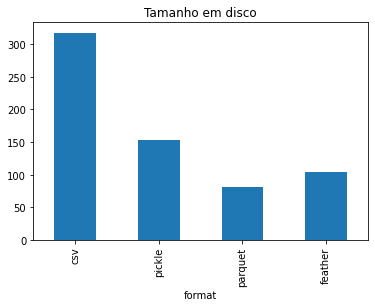

In [ ]:
results_size.set_index('format')['size'].plot(kind='bar', title='Tamanho em disco')

In [ ]:
results_write = pd.DataFrame(
    [
        ['csv', 75000], 
        ['pickle',170], 
        ['parquet',1200], 
        ['feather',461]
    ],
    columns=['format','time']
)

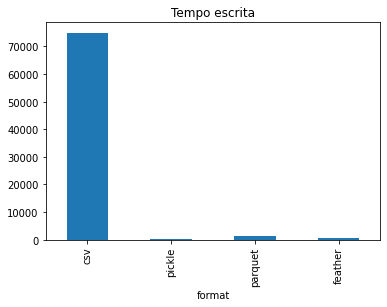

In [ ]:
results_write.set_index('format')['time'].plot(kind='bar', title='Tempo escrita')

In [ ]:
results_read = pd.DataFrame(
    [
        ['csv', 4300], 
        ['pickle',55.1], 
        ['parquet',464], 
        ['feather',285]
    ],
    columns=['format','time']
)

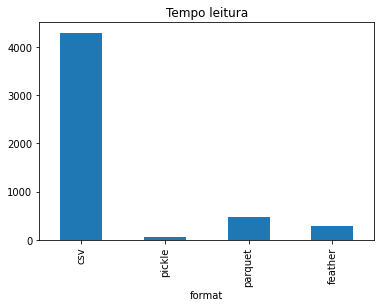

In [ ]:
results_read.set_index('format')['time'].plot(kind='bar', title='Tempo leitura')

Para a escolha do formato é necessário levar em consideração se o arquivo será compartilhado com alguém que vai abrí-lo no Excel, então a melhor opção talvez seja o .csv.

Mas caso o tamanho em disco seja a prioridade, a melhor opção é o parquet. E então, se o objetivo for a velocidade de escrita e leitura o pickle obteve o melhor resultado.  



#### **E por que essa preocupação toda?** 



Imagine que todos esses dados estejam armazenados em um ambiente em nuvem, que é super comum hoje em dia, quanto maior o armazenamento e maior tráfego de dados maior será o seu custo. 

Então, escolher formatos de dados, formatos de arquivos que deixam o armazenamento dos dados ocupando menores espaços em disco e funções de processamento mais rápidas vão economizar seus recursos em nuvem e, consequentemente, economizar nos gastos no fim do mês!   

E por último, mas não menos importante, vou deixar as referências que me ajudaram a construir esse artigo, afinal material bom tem que ser compartilhado:

* Canal Youtube: https://www.youtube.com/@robmulla
* Livro: Python for Data Analysis
* Artigo Medium: https://towardsdatascience.com/generating-fake-data-with-pandas-very-quickly-b99467d4c618
* Artigo Acervo Lima: https://acervolima.com/vetorizacao-em-python/
* Artigo Medium: https://medium.com/geleia/otimizando-c%C3%B3digos-de-data-science-em-python-com-vetoriza%C3%A7%C3%A3o-b5cd9188530c





É isso, espero ter contribuído com essas dicas! Até o próximo! 

<div align="center"><img src="https://media.tenor.com/44WZ5UwIw6MAAAAM/wave-panda.gif"/>
</div>

